<a href="https://colab.research.google.com/github/AloniRegev/Defense-Against-Adversarial-Examples-in-NN/blob/Neta-dev/DL_project_adversary_attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CUDA available. Training on GPU
Files already downloaded and verified
 trainset: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
           )
Files already downloaded and verified
train set len 40000
validation set len 10000
test set len 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d

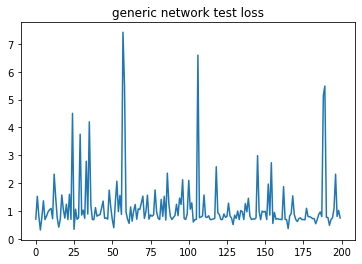

Accuracy: in test 0.10999999940395355


In [6]:
from torch._C import NoneType
import torch
import torchvision
import torchvision.datasets as datasets
from torch import optim
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as data
from torchsummary import summary

import copy
from PIL import Image
from scipy import ndimage


def load_dataset():
    transform_train = transforms.Compose([
        # agmentation below
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        # regular normalization
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    # Normalize the test set same as training set without augmentation
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    print(f' trainset: {trainset}')
    # print(f' trainset shape: {trainset.size()}')

    ## script to find mean
    # data = trainset.data / 255  # data is numpy array
    #
    # mean = data.mean(axis=(0, 1, 2))
    # std = data.std(axis=(0, 1, 2))
    # print(f"Mean : {mean}   STD: {std}")  # Mean : [0.491 0.482 0.446]   STD: [0.247 0.243 0.261]

    cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True,
                                     transform=transform_test)  # transform_test
    cifar_trainset, cifar_valset = data.random_split(trainset, [int(len(trainset) * 0.8), int(len(
        trainset) * 0.2)])  # split the trainset to trainset and validation set in 80%-20% retio

    print('train set len', len(cifar_trainset))
    print('validation set len', len(cifar_valset))
    print('test set len', len(cifar_testset))

    number_workers = 0
    if device == torch.device('cuda'):
        number_workers = 2
    train_loader = data.DataLoader(cifar_trainset, shuffle=True, batch_size=64, num_workers=number_workers)
    val_loader = data.DataLoader(cifar_valset, shuffle=False, batch_size=64, num_workers=number_workers)
    test_loader = data.DataLoader(cifar_testset, shuffle=False, batch_size=64, num_workers=number_workers)

    test_for_adv = data.DataLoader(cifar_testset, shuffle=False, batch_size=1)
    train_for_adv = data.DataLoader(cifar_trainset, shuffle=True, batch_size=1)
    return train_loader, val_loader, test_loader, test_for_adv, train_for_adv


# model3:  with dropout, with batch, without fc layers


class CNN_model(nn.Module):  # TODO: fix so I get correct dimensions of output
    def __init__(self):
        super(CNN_model, self).__init__()
        self.feature_extractor = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=1),

        )

    def forward(self, x):
        # conv layers
        features = self.feature_extractor(x)
        # print("features shape:", features.shape)

        # final non fully connected
        class_scores = self.classifier(features)
        # print("class_scores shape:", class_scores.shape)
        class_scores = torch.reshape(class_scores, (class_scores.size(dim=0), class_scores.size(dim=1)))
        # print("class_scores shape:", class_scores.shape)

        return class_scores


# Train
def train_data(model, epochs, learning_rate, loss_function, train_loader, valid_loader, PATH, filtered_images=[],
               patience=4):
    loss_arr = []
    avg_train_loss_arr, avg_val_loss_arr = [], []
    train_acc_arr, val_acc_arr = [], []
    # Early stopping  parameters
    last_loss = 100  # initializing max loss as high unreachable value
    trigger_times = 0
    total, correct = 0.0, 0.0

    # for i in range(5):
    #   data_iter = iter(filtered_images)
    #   pert_image_numpy = next(data_iter)[i].cpu().detach().squeeze().numpy()
    #   print(pert_image_numpy.shape)
    #   plt.figure()
    #   plt.imshow(pert_image_numpy.transpose(1, 2, 0))
    #   #plt.title(label_pert)
    #   plt.show()

    # images = next(data_iter)
    # print(type(images))
    # print(images.shape)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00012)

    # dataiter = iter(train_loader)
    # images, labels = dataiter.next()
    # print(type(images))
    # print(images.shape)
    # print(labels.shape)

    for epoch in range(epochs):
        model.train()  # defining we're training so can use dropout, batch norm
        if len(filtered_images) > 0:
            feature_squeezing = True
            data_iter = iter(filtered_images)
        for i, (inputs, labels) in enumerate(train_loader, 0):
            if device == torch.device('cuda'):
                inputs = inputs.to(device)
                labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward and backward propagation
            if feature_squeezing:
              batch_cur = []
              for j in range(len(inputs)):
                  cur_img = ndimage.median_filter(inputs[j].cpu().detach(), size=(2, 2, 2), origin=-1)  # mode is reflect by default  # sliding window size is: (2,2), shifted to image right
                  batch_cur.append(cur_img)
                  #squeezed_images.append(torch.tensor(np.array(batch_cur)))
              outputs = model(torch.tensor(np.array(batch_cur)).to(device))
              #outputs = model(next(data_iter).to(device))
            else:
                outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss_arr.append(loss.item())
            loss.backward()
            optimizer.step()

            # Show progress
            if i % 100 == 0 or i == len(train_loader):
                # print('[{}/{}, {}/{}] loss: {:.8}'.format(epoch, epochs, i, len(train_loader), loss.item()))
                print("Iteration: {0} | Loss: {1} | index {2} ".format(epoch, loss.item(), i))

            total += inputs.shape[0]
            predictions = torch.argmax(outputs.data, dim=1)
            correct += torch.sum(predictions == labels).type(torch.float32)

        # print("total is: {0}, len(train_loader): {1}, correct pred num is: {2}".format(total, len(train_loader), correct))
        train_acc = (correct / total).item()
        print('Accuracy: in train', train_acc)
        train_acc_arr.append(train_acc)

        plot_graph(loss_arr, "generic network training loss")
        avg_train_loss_arr.append(np.mean(loss_arr))
        # Early stopping
        current_loss, avg_val_loss, val_acc = validation_data(model, valid_loader)
        print('The Current Loss by validation data:', current_loss)
        avg_val_loss_arr.append(avg_val_loss.item())
        val_acc_arr.append(val_acc)

        if current_loss > last_loss:
            trigger_times += 1
            # print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                break  # exit loop, print data

        else:
            # print('trigger times did not increase:' , trigger_times)
            torch.save(model.state_dict(), PATH)
            trigger_times = 0

        last_loss = current_loss

    model.load_state_dict(torch.load(PATH))
    plot_graph(loss_arr, "generic network training loss")

    title = "avg train loss vs avg validation loss"
    plot_two_graphs(avg_train_loss_arr, avg_val_loss_arr, title, 'train loss', 'val loss', 'loss',
                    'avg_train_loss_vs_avg_validation_loss')

    title = "avg train acc vs avg validation acc"
    plot_two_graphs(train_acc_arr, val_acc_arr, title, 'train accuracy', 'validation accuracy', 'accuracy',
                    'avg_train_acc_vs_avg_validation_acc')

    return model


def plot_graph(list, title):
    plt.plot(list)
    plt.title(title)
    plt.show()

def plot_two_graphs(list1, list2, title, label1, label2, y_label, plot_path):
    plt.plot(list1, label=label1)
    # Plot another line on the same chart/graph
    plt.plot(list2, label=label2)
    plt.title(title)
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel(y_label)
    plt.savefig('./outputs/'+plot_path+'.png')
    plt.show()


def validation_data(model, valid_loader):
    model.eval()
    total = 0
    correct = 0
    loss_total = 0.0
    loss_arr = []

    # iterate over test data
    with torch.no_grad():  # disable gradients because we only run on test data
        for (data, labels) in valid_loader:
            # move tensors to GPU if CUDA is available
            if device == torch.device('cuda'):
                data, labels = data.cuda(), labels.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss_valid = loss_fn(output, labels)
            loss_arr.append(loss_valid.item())
            loss_total += loss_valid.item()

            total += data.shape[0]
            predictions = torch.argmax(output.data, dim=1)
            correct += torch.sum(predictions == labels).type(torch.float32)

    # plot_graph(loss_arr, "generic network valid loss")
    acc = (correct / total)
    print('Accuracy: in validation', acc.item())

    return (loss_total / len(valid_loader)), np.mean(loss_arr), acc.item()


def test_data(model, test_loader):
    model.eval()
    total = 0
    correct = 0
    loss_arr = []

    # iterate over test data
    with torch.no_grad():  # disable gradients because we only run on test data
        for (data, labels) in test_loader:
            # move tensors to GPU if CUDA is available
            if device == torch.device('cuda'):
                data, labels = data.cuda(), labels.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss_test = loss_fn(output, labels)
            loss_arr.append(loss_test.item())

            total += data.shape[0]
            predictions = torch.argmax(output.data, dim=1)
            correct += torch.sum(predictions == labels).type(torch.float32)

    plot_graph(loss_arr, "generic network test loss")

    print('Accuracy: in test', (correct / total).item())


def deepfool(image, model, num_classes=10, overshoot=0.02, max_iter=10):  # overshoot prevents vanishing updates
    model.eval()
    # print('in deepfool before first forward')

    image.requires_grad = True
    out_orig = model.forward(image.to(device))

    temp = np.array(out_orig.cpu().detach().numpy())  # getting image prediction labels
    labels = temp.flatten().argsort()[::-1]  # labels indexes from low to high
    # print(labels)
    # print('after first')

    labels = labels[0:num_classes]  # starting with label with highest prediction
    label = labels[0]

    input_shape = image.detach().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    pert_tot = np.zeros(input_shape)
    ctr = 0

    x = pert_image[None, :].clone().detach().requires_grad_(True).to(device)
    x.retain_grad()
    out = model.forward(x[0])
    # print('after second forward')
    label_cur = label

    while label_cur == label and ctr < max_iter:  # and x.grad is not None

        pert = np.inf
        # print('before backward 1')
        out[0, labels[0]].backward(
            retain_graph=True)  # retain_graph for iterating through the graph after the first time
        # print(x.grad)
        grad_orig = x.grad.data.cpu().detach().numpy().copy()

        for i in range(1, num_classes):  # finding hyperplane which gives smallest difference between all classes
            # print('before backward 2')
            out[0, labels[i]].backward(retain_graph=True)
            cur_grad = x.grad.data.cpu().detach().numpy().copy()

            w_cur = cur_grad - grad_orig
            out_diff = (out[0, labels[i]] - out[0, labels[
                0]]).data.cpu().detach().numpy()  # difference between prediction of original image and perturbed

            # using formula to calculate current hyperplane
            hyperplane_cur = abs(out_diff) / np.linalg.norm(w_cur.flatten())

            # getting minimal change hyperplane
            if hyperplane_cur < pert:
                pert = hyperplane_cur
                w = w_cur

        # Added 1e-4 for numerical stability
        pert_cur = (pert + 1e-4) * w / np.linalg.norm(w)
        # calculating new perturbed image to updated image under min hyperplane such that her projection changed
        pert_tot = np.float32(pert_tot + pert_cur)

        pert_image = image.cpu().detach() + (1 + overshoot) * torch.from_numpy(pert_tot)

        x = pert_image.clone().detach().requires_grad_(True).to(device)
        x.retain_grad()
        # print('before final forward')
        out = model.forward(x[0])
        label_cur = np.argmax(out.data.cpu().detach().numpy().flatten())  # label of pert image

        ctr += 1

    pert_tot = (1 + overshoot) * pert_tot

    return pert_tot, ctr, label, label_cur, pert_image


# def batched_deepfool(model, batch):
#     sum_diff = 0
#     adv_images = []
#     for j in range(len(batch)):  # images one by one
#         r, loop_i, label_orig, label_pert, pert_image = deepfool(batch[j].unsqueeze(0), model, max_iter=50)
#         # if label_orig != label_pert:
#         #     sum_diff += 1
#         adv_images.append(pert_image.detach().squeeze().to(device))
#     # print(pert_image.detach().squeeze().to(device).shape)
#     # print(torch.stack(adv_images).shape)
#     final = torch.stack(adv_images)
#     return final


# def batched_deepfool_train(model, train_loader):  # applying deepfool on each batch and whole train loader
#     adv_images = []
#     for i, (batch, labels) in enumerate(train_loader, 0):
#         batch_cur = []
#         for j in range(len(batch)):
#             r, loop_i, label_orig, label_pert, pert_image = deepfool(batch[j].unsqueeze(0), model, max_iter=50)
#             batch_cur.append(pert_image.detach().squeeze().to(device))
#         adv_images.append(torch.stack(batch_cur))
#     print(pert_image.detach().squeeze().to(device).shape)
#     print(torch.stack(adv_images).shape)
#     final = torch.stack(adv_images)
#     torch.save(final, 'final_adv_images.pt')
#     return final


def calling_deepfool(model, xLoader):
    sum_diff = 0
    misclassified = []
    for i, (image, label) in enumerate(xLoader):
        if device == torch.device('cuda'):
            image, label = image.cuda(), label.cuda()
        r, loop_i, label_orig, label_pert, pert_image = deepfool(image, model, max_iter=50)
        if label_orig != label.item():
          print(f'label_orig: {label_orig}, label: {label}')
        misclassified.append((pert_image.detach().squeeze(0).to(device), label))
        if label_orig != label_pert:
            sum_diff += 1
        if sum_diff ==200:
            print(f'index is: {i}, sum_diff is: {sum_diff}')
            break
    print(f'index is: {i}, sum_diff is: {sum_diff}')
    acc = 1 - (sum_diff / (i + 1))
    print('Accuracy: in test of deepfool', acc)  # accuracy on perturbed images

    # pert_image_numpy = pert_image.detach().squeeze().numpy()
    # print(pert_image_numpy.shape)
    # plt.figure()
    # plt.imshow((pert_image_numpy * 255).astype(np.uint8).transpose(1, 2, 0))
    # plt.title(label_pert)
    # plt.show()

    # plt.figure()
    # origin = image.cpu().detach().squeeze().numpy()
    # plt.imshow((origin * 255).astype(np.uint8).transpose(1, 2, 0))
    # plt.title(label.item())
    # plt.show()

    # r_new = r.squeeze().numpy()

    # plt.figure()
    # plt.imshow((r_new * 255).astype(np.uint8).transpose(1, 2, 0))
    # plt.show()

    return misclassified


def adversarial_train(model, epochs, learning_rate, loss_function, train_loader, valid_loader,  PATH, adv_images=[]):
    loss_arr = []
    loss_clean_data = []
    loss_pert_data = []
    acc_clean_data = []
    acc_pert_data = []

    avg_train_loss_arr = []
    avg_loss_clean_data = []
    avg_loss_pert_data = []

    val_loss = []
    val_acc = []
    total_train_acc = []
    # # Early stopping  parameters
    # last_loss = 100  # initializing max loss as high unreachable value
    # trigger_times = 0

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00012)
    total, correct = 0.0, 0.0
    total_adv, correct_adv = 0.0, 0.0
    step = 0
    # breakstep = 0
    for epoch in range(epochs):
        if len(adv_images) ==0:
            fgsm_attack = True

            eps = 0.1
        else:
            itr = iter(adv_images)
        model.train()  # defining we're training so can use dropout, batch norm
        for i, (inputs, labels) in enumerate(train_loader, 0):
            if device == torch.device('cuda'):
                inputs = inputs.to(device)
                labels = labels.to(device)
            # Zero the gradients
            optimizer.zero_grad()
            # Forward and backward propagation
            inputs.requires_grad_(True).retain_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss_arr.append(loss.item())
            loss_clean_data.append(loss.item())
            loss.backward()
            optimizer.step()
            predictions = torch.argmax(outputs.data, dim=1)
            correct += torch.sum(predictions == labels).type(torch.float32)
            total += train_loader.batch_size

            # Adversarial Training

            if fgsm_attack:
                grad = inputs.grad.data
                perturbed_x = CreateAttack(inputs, eps, grad)
                # Zero the gradients
                optimizer.zero_grad()
                outputs = model(perturbed_x.to(device))

            else:
                # adv_images = batched_deepfool(model, inputs)
                # adv_images[i] = adv_images[i].to(device)
                cur_adv_image = next(itr)
                optimizer.zero_grad()
                # Forward and backward propagation
                # pert_image = pert_image.clone().detach().squeeze(1).to(device)
                outputs = model(cur_adv_image)
            # outputs = model(adv_images)
            loss = loss_function(outputs, labels)
            loss_arr.append(loss.item())
            loss_pert_data.append(loss.item())
            loss.backward()
            optimizer.step()
            predictions = torch.argmax(outputs.data, dim=1)
            correct_adv += torch.sum(predictions == labels).type(torch.float32)
            total_adv += train_loader.batch_size

            step += 1
            if total % 500 == 0:
                acc = float(correct) / total
                print('[%s] Clean Training accuracy: %.2f%%' % (step, acc * 100))
                accAdv = float(correct_adv) / total_adv
                print('[%s] Adv Training accuracy: %.2f%%' % (step, accAdv * 100))

        train_acc = (correct / total)
        print('Accuracy clean data: in train', train_acc)
        acc_clean_data.append(train_acc)

        plot_graph(loss_arr, "generic network training loss")
        avg_train_loss_arr.append(np.mean(loss_arr))

        plot_graph(avg_loss_clean_data, "clean data network training loss")
        avg_loss_clean_data.append(np.mean(loss_clean_data))

        plot_graph(avg_loss_pert_data, "pert data network training loss")
        avg_loss_pert_data.append(np.mean(loss_pert_data))

        train_adv_acc = (correct_adv / total_adv)
        print('Accuracy adv: in train', train_adv_acc)
        acc_pert_data.append(train_adv_acc)

        current_loss, avg_val_loss, curr_val_acc = validation_data(model, valid_loader)
        print('The Current Loss by validation data:', current_loss)
        val_loss.append(avg_val_loss)
        val_acc.append(curr_val_acc)

        total_acc = float(correct + correct_adv) / (total_adv + total)
        total_train_acc.append(total_acc)

    plot_graph(loss_arr, "generic network training loss")
    torch.save(model.state_dict(), PATH)

    title = "adversary train loss on clean data vs loss on perturbed data"
    plot_two_graphs(avg_loss_pert_data, avg_loss_clean_data, title, 'loss pert data', 'loss clean data','loss',
                    'train_loss_clean_vs_pert')

    title = "accuracy on clean data vs accuracy on perturbed data"
    plot_two_graphs(acc_pert_data, acc_clean_data, title, 'pert data acc', 'clean data acc','accuracy',
                    'acc_clean_vs_pert')

    title = "adversary train loss vs avg validation loss"
    plot_two_graphs(avg_train_loss_arr, avg_val_loss, title, 'train loss', 'val loss','loss',
                    'adv_train_loss_vs_avg_validation_loss')

    title = "adversary train acc vs avg validation acc"
    plot_two_graphs(total_train_acc, val_acc, title, 'train accuracy', 'validation accuracy', 'accuracy',
                    'adv_train_acc_vs_avg_validation_acc')

    return model


# def feature_squeezing2(train_loader):  # applying deepfool on each batch and whole train loader
#     squeezed_images = []
#     for i, (inputs, labels) in enumerate(train_loader, 0):
#         batch_cur = []
#         for j in range(len(inputs)):
#             cur_img = ndimage.median_filter(inputs[j], size=(2, 2, 2), origin=-1)  # mode is reflect by default
#             # sliding window size is: (2,2), shifted to image right
#             batch_cur.append(cur_img)
#             # if i<3 and j<3:
#             #   pert_image_numpy = cur_img.squeeze()
#             #   print(pert_image_numpy.shape)
#             #   plt.figure()
#             #   plt.imshow(pert_image_numpy.transpose(1, 2, 0))
#             #   #plt.title(label_pert)
#             #   plt.show()
#             #
#             #   image_numpy = inputs[j].detach().squeeze().numpy()
#             #   print(image_numpy.shape)
#             #   plt.figure()
#             #   plt.imshow(image_numpy.transpose(1, 2, 0))
#             #   #plt.title(label_pert)
#             #   plt.show()
#         squeezed_images.append(torch.tensor(np.array(batch_cur)))
#     print(torch.stack(squeezed_images).shape)
#     final = torch.stack(squeezed_images)
#     torch.save(final, 'squeezed_images.pt')
#     return final

def CreateAttack(x, eps, grad): # fgsm attack
    perturbed_x = x + eps*torch.sign(grad)
    return perturbed_x


def Checker(model, xLoader, eps):
    model.eval()
    perturbed_images = []
    correct_n, correct, total =0,0,0
    loss_fn = nn.CrossEntropyLoss()
    for i, (image, labels) in enumerate(xLoader):
        if device==torch.device('cuda'):
            image, labels = image.cuda(), labels.cuda()
        image.requires_grad = True
        output = model(image)
        loss= loss_fn(output, labels)
        loss.backward()
        grad = image.grad.data # getting image gradient
        perturbed_x = CreateAttack(image, eps, grad)
        output_adv = model(perturbed_x.to(device)) # applying model on perturbed image to get prediction
        #print("model output adversary output in checker: ",  output_adv)
        predictions = torch.argmax(output_adv, dim=1)
        correct = torch.sum(predictions == labels).type(torch.float32).item() #see if image was classified wrong
        total += labels.shape[0]
        if (correct != 1):
            perturbed_images.append(perturbed_x)  # perturbed classification correct, add to list to present later
        if(correct==1):
            correct_n+=1

    acc = (correct_n / total)
    print('Accuracy: in test', acc) # accuracy on perturbed images
    return acc, perturbed_images


if __name__ == '__main__':
    global device
    device = torch.device('cpu')
    # check if cuda is available
    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        device = torch.device('cuda')
        print("CUDA available. Training on GPU")
    else:
        print("CUDA is not available. Training on CPU")

    train_loader, val_loader, test_loader, test_for_adv, train_for_adv = load_dataset()
    batch_size = 64
    max_epochs = 80  # number of steps between evaluations
    loss_fn = nn.CrossEntropyLoss()

    # step 1 - initialize and train model
    model = CNN_model().to(device)  # with dropout, batch, without FC layers
    summary(model, input_size=(3, 32, 32))
    print(model)

    PATH = './model.pth'
    # model = train_data(model, 100, 0.0001, loss_fn, train_loader, val_loader, PATH)
    # torch.save(model.state_dict(), PATH)

    model.load_state_dict(torch.load(PATH, map_location=torch.device(device)))
    # model.load_state_dict(torch.load(PATH))
    # test_data(model, test_loader)
    print('\n\nFinished Training model\n\n')

    # step 2: adv attack - deep fool on clean data
    # attacked_deepfool = calling_deepfool(model, test_for_adv)
    # test_data(model, attacked_deepfool)

    # adv_images = batched_deepfool_train(model, train_loader)
    # print('\n\nFinished creating batched images\n\n')

    # # step 3: adv training and then retest deepfool
    # tensor_adv_images = torch.load('./final_adv_images.pt', map_location=torch.device(device))
    # print(tensor_adv_images.shape)

    # PATH_ADV = './model_train_adv.pth'
    # epochs = 5  # was 100
    # model_adv_train = adversarial_train(model, epochs, 0.0001, loss_fn, train_loader, val_loader, PATH_ADV, tensor_adv_images)
    #
    # test_data(model_adv_train, test_loader)
    #
    # adv_training_deepfool = calling_deepfool(model_adv_train, test_for_adv)
    #
    # test_data(model_adv_train, adv_training_deepfool)

    # # step 4: fgsm adversarial training

    # PATH_ADV_fgsm = './model_train_adv_fgsm.pth'
    # epochs = 100  # was 100
    # model_adv_train_fg = CNN_model().to(device)
    # #model_adv_train_fg = adversarial_train(model, epochs, 0.0001, loss_fn, train_loader, val_loader, PATH_ADV_fgsm)
    # model_adv_train_fg.load_state_dict(torch.load(PATH_ADV_fgsm))
    # Checker(model_adv_train_fg, test_for_adv, 0.1)



    # step 5: apply feauture squeezing defense and then test deepfool attack
    #feature_squeezing2(train_loader)
    #squeezed_images = torch.load('squeezed_images.pt', map_location=torch.device(device))
    PATH_SQUEEZED = './model_squeezed.pth'
    model_squeezed_train = CNN_model().to(device)
    # model_squeezed_train = train_data(model_squeezed_train, 100, 0.0001, loss_fn, train_loader, val_loader,
    #                                   PATH_SQUEEZED, squeezed_images)  # squeezed_images instead train loader

    model_squeezed_train.load_state_dict(torch.load(PATH_SQUEEZED, map_location=torch.device(device)))

    # test_data(model_squeezed_train, test_loader)

    # adv attack - deep fool on pre-processed data data
    attacked_deepfool_squeezed_im = calling_deepfool(model_squeezed_train, test_for_adv)

    test_data(model_squeezed_train, attacked_deepfool_squeezed_im)

index is: 199, sum_diff is: 200
index is: 199, sum_diff is: 200
Accuracy: in test of deepfool 0.0


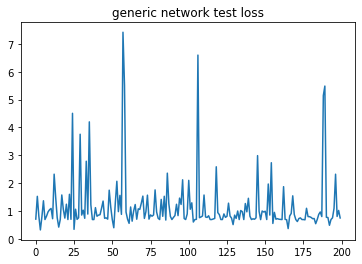

Accuracy: in test 0.10999999940395355
